## Error plot with respect to $\beta$

In [16]:
using TracyWidomBeta,LinearAlgebra,Statistics,SparseArrays,Distributions,Trapz,ApproxFun,SpecialFunctions
using RandomMatrices,Plots,LaTeXStrings,TypedTables,StatsBase,FFTW

To compute the errors, we treat the following as the ground truths.

In [17]:
TW2=TracyWidom;
F1=Fun(x->cdf(TW2,x; beta=1,num_points=300),-10..13);
F2=Fun(x->cdf(TW2,x; beta=2,num_points=300),-10..13);
F4=Fun(x->cdf(TW2,x; beta=4,num_points=300),-10..13);
f1=F1';
f2=F2';
f4=F4';

The following plot shows how the absolute error (CDF) over the entire domain $x\in[-10,13]$ changes with respect $\beta=1,2,4$. $\Delta x=-0.001$ and $M=8000$ are used.

In [18]:
function errs_cdf(D)
    ers_cdf=Plots.plot();
    beta=[1,2,4];
    err1=zeros(length(D),1);
    err2=zeros(length(D),1);
    err4=zeros(length(D),1);
    for j=1:length(beta)
        global β=beta[j]
        F_cdf=TW(β;method="spectral",step="bdf5")
        for i=1:length(D)
            temp=D[i]
            if β==4
                err4[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            elseif β==1
                err1[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            elseif β==2
                err2[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        end
        for i=1:length(D)
            if err1[i]<10^(-16)
                err1[i]=10^(-16)
            end
            if err2[i]<10^(-16)
                err2[i]=10^(-16)
            end
            if err4[i]<10^(-16)
                err4[i]=10^(-16)
            end
        end
        if β==1
            ers_cdf=Plots.plot!(D,err1,lw=5,label=L"$\beta=1$",legend=:bottomleft,yaxis=:log10,xtickfontsize=15,ytickfontsize=15,
                legendfontsize=10,yticks=[10^(-16),10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),
                    10^(-6),10^(-5)],xticks=D[end]:2:D[1])
        elseif β==2
            ers_cdf=Plots.plot!(D,err2,lw=5,label=L"$\beta=2$",legend=:bottomleft,yaxis=:log10,xtickfontsize=15,ytickfontsize=15,
                legendfontsize=10,yticks=[10^(-16),10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),
                    10^(-6),10^(-5)],xticks=D[end]:2:D[1])
        elseif β==4
            ers_cdf=Plots.plot!(D,err4,lw=5,label=L"$\beta=4$",legend=:bottomleft,yaxis=:log10,xtickfontsize=15,ytickfontsize=15,
                legendfontsize=10,yticks=[10^(-16),10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),
                    10^(-6),10^(-5)],xticks=D[end]:2:D[1])
        end
    end
    return ers_cdf
end

errs_cdf (generic function with 1 method)

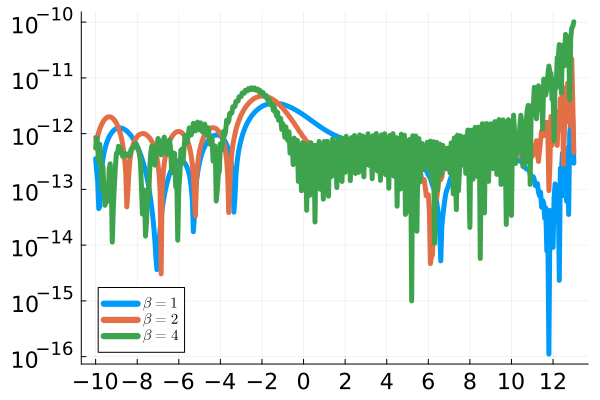

In [19]:
D=13:-0.05:-10;
ers_cdf=errs_cdf(D)

The following code outputs a table showing the absolute errors of BDF5 for $x=0,\pm 2,\pm 4,\pm 6, \pm 8$, $\beta=1,2,4$, $\Delta x=-0.001$, $M=16000$.

In [20]:
X=-8:2:8;
err=zeros(length(X),3);
B=[1,2,4];
for i=1:length(B)
    global β=B[i]
    F_cdf=TW(β;method="spectral",step="bdf5")
    for j=1:length(X)
        temp=X[j]
        if β==4
            err[j,3]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
        elseif β==1
            err[j,1]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
        elseif β==2
            err[j,2]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
        end
    end
end
err1=err[:,1];err2=err[:,2];err4=err[:,3];

In [21]:
Table(x=X,β1=err1,β2=err2,β4=err4)

Table with 4 columns and 9 rows:
     x   β1           β2           β4
   ┌──────────────────────────────────────────
 1 │ -8  5.91169e-13  8.84549e-13  5.85796e-13
 2 │ -6  3.27741e-13  1.09595e-12  1.02299e-13
 3 │ -4  9.06186e-13  9.91283e-13  6.59028e-13
 4 │ -2  3.0686e-12   4.71861e-12  5.16132e-12
 5 │ 0   2.16238e-12  8.66862e-13  2.36811e-13
 6 │ 2   7.91811e-13  4.88054e-13  2.01394e-13
 7 │ 4   5.69989e-13  4.96159e-13  6.5925e-13
 8 │ 6   1.81632e-13  8.01581e-14  3.09308e-13
 9 │ 8   4.11227e-13  6.75904e-13  2.07612e-14

Similarly, the following plot is for the PDF.

In [22]:
function errs_pdf(D)
    ers_pdf=Plots.plot();
    beta=[1,2,4];
    err1=zeros(length(D),1);
    err2=zeros(length(D),1);
    err4=zeros(length(D),1);
    for j=1:length(beta)
        global β=beta[j]
        F_pdf=TW(β;method="spectral",step="bdf5",pdf=true)
        for i=1:length(D)
            temp=D[i]
            if β==4
                err4[i]=abs(F_pdf(temp/(2^(1/6)))*(2^(-1/6))-f4(temp))
            elseif β==1
                err1[i]=abs(F_pdf(temp)-f1(temp))
            elseif β==2
                err2[i]=abs(F_pdf(temp)-f2(temp))
            end
        end
        for i=1:length(D)
            if err1[i]<10^(-16)
                err1[i]=10^(-16)
            end
            if err2[i]<10^(-16)
                err2[i]=10^(-16)
            end
            if err4[i]<10^(-16)
                err4[i]=10^(-16)
            end
        end
        if β==1
            ers_pdf=Plots.plot!(D,err1,lw=5,label=L"$\beta=1$",legend=:bottomleft,yaxis=:log10,xtickfontsize=15,ytickfontsize=15,
                legendfontsize=10,yticks=[10^(-16),10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),
                    10^(-6),10^(-5)],xticks=D[end]:2:D[1])
        elseif β==2
            ers_pdf=Plots.plot!(D,err2,lw=5,label=L"$\beta=2$",legend=:bottomleft,yaxis=:log10,xtickfontsize=15,ytickfontsize=15,
                legendfontsize=10,yticks=[10^(-16),10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),
                    10^(-6),10^(-5)],xticks=D[end]:2:D[1])
        elseif β==4
            ers_pdf=Plots.plot!(D,err4,lw=5,label=L"$\beta=4$",legend=:bottomleft,yaxis=:log10,xtickfontsize=15,ytickfontsize=15,
                legendfontsize=10,yticks=[10^(-16),10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),
                    10^(-6),10^(-5)],xticks=D[end]:2:D[1])
        end
    end
    return ers_pdf
end

errs_pdf (generic function with 1 method)

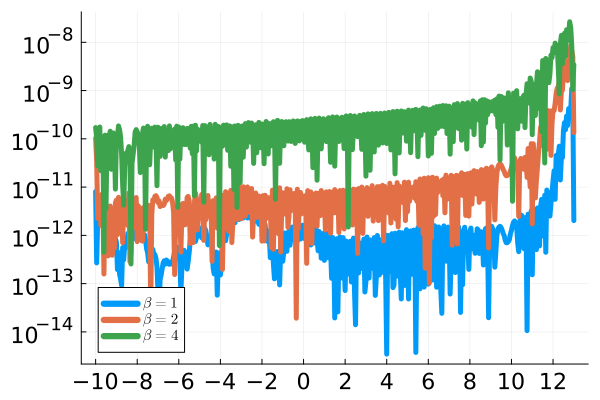

In [23]:
D=13:-0.05:-10;
ers_pdf=errs_pdf(D)

## Error plots with respect to $\left|\Delta x\right|$ and $M$

The following plots show how the absolute error (CDF) over the entire domain $x\in[-10,13]$ changes when $\left|\Delta x\right|$ decreases and $M$ increases for a fixed $\beta$-value. $\Delta x=-0.2,-0.1,-0.05$ and $M=8000$ are used.

In [24]:
function errs_cdfc(β,D)
    ers_cdfc=Plots.plot();
    delta_x=[-0.2,-0.1,-0.05];
    for j=1:length(delta_x)
        err=zeros(length(D),1)
        dx=delta_x[j];
        F_cdf=TW(β;method="spectral",step="bdf5",Δx_s=dx)
        for i=1:length(D)
            temp=D[i]
            if β==4
                err[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            elseif β==1
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            elseif β==2
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        end
        for i=1:length(D)
            if err[i]<10^(-16)
                err[i]=10^(-16)
            end
        end
        if j==1
            ers_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=9,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),10^(6),10^(8),
                    10^(10),10^(12),10^(14),10^(16)],xticks=D[end]:2:D[1],legend=:bottom)
        elseif j==2
            ers_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=9,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),10^(6),10^(8),
                    10^(10),10^(12),10^(14),10^(16)],xticks=D[end]:2:D[1],legend=:bottom)
        elseif j==3
            ers_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.05$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,
                legendfontsize=9,yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),
                    10^(6),10^(8),10^(10),10^(12),10^(14),10^(16)],xticks=D[end]:2:D[1],legend=:bottom)
        end
    end
    return ers_cdfc
end

errs_cdfc (generic function with 1 method)

For $\beta=1$, we have

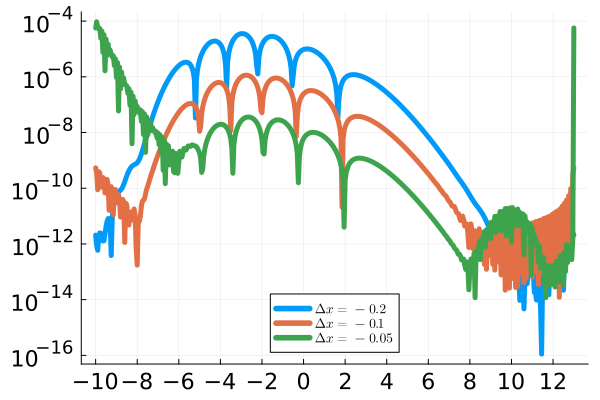

In [25]:
D=13:-0.05:-10;
ers_cdfc=errs_cdfc(1,D)

For $\beta=2$, we have

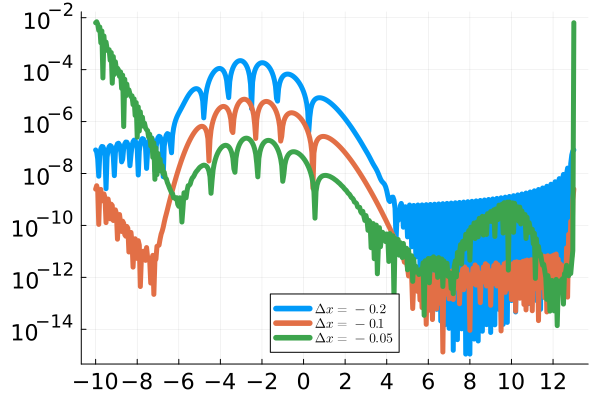

In [26]:
D=13:-0.05:-10;
ers_cdfc=errs_cdfc(2,D)

For $\beta=4$, we have

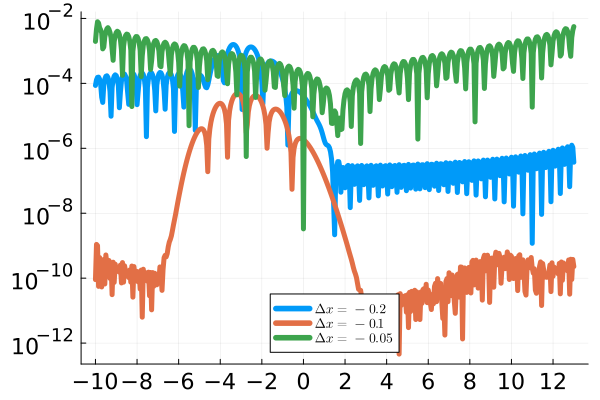

In [27]:
D=13:-0.05:-10;
ers_cdfc=errs_cdfc(4,D)

Similarly, the following algorithm is for the PDF.

In [28]:
function errs_pdfc(β,D)
    ers_pdfc=Plots.plot();
    delta_x=[-0.2,-0.1,-0.05];
    for j=1:length(delta_x)
        err=zeros(length(D),1)
        dx=delta_x[j];
        F_pdf=TW(β;pdf=true,method="spectral",step="bdf5",Δx_s=dx)
        for i=1:length(D)
            temp=D[i]
            if β==4
                err[i]=abs(F_pdf(temp/(2^(1/6)))*(2^(-1/6))-f4(temp))
            elseif β==1
                err[i]=abs(F_pdf(temp)-f1(temp))
            elseif β==2
                err[i]=abs(F_pdf(temp)-f2(temp))
            end
        end
        for i=1:length(D)
            if err[i]<10^(-16)
                err[i]=10^(-16)
            end
        end
        if j==1
            ers_pdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),10^(6),10^(8),
                    10^(10)],xticks=D[end]:2:D[1],legend=:bottom)
        elseif j==2
            ers_pdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),10^(6),10^(8),
                    10^(10)],xticks=D[end]:2:D[1],legend=:bottom)
        elseif j==3
            ers_pdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.05$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),10^(6),10^(8),
                    10^(10)],xticks=D[end]:2:D[1],legend=:bottom)
        end
    end
    return ers_pdfc
end

errs_pdfc (generic function with 1 method)

For $\beta=1$, we have

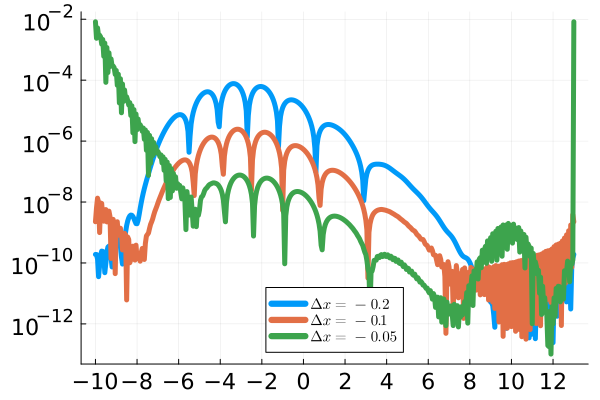

In [29]:
D=13:-0.05:-10;
ers_pdfc=errs_pdfc(1,D)

For $\beta=2$, we have

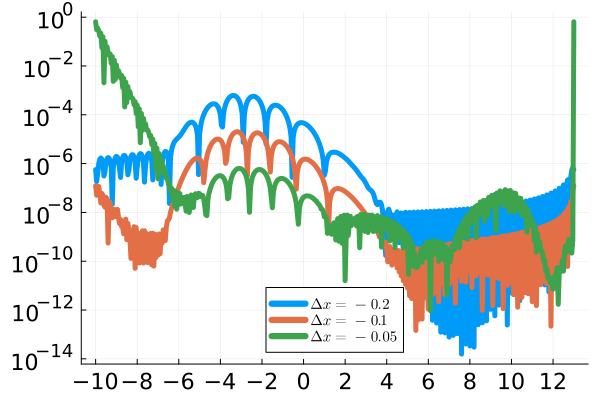

In [30]:
D=13:-0.05:-10;
ers_pdfc=errs_pdfc(2,D)

For $\beta=4$, we have

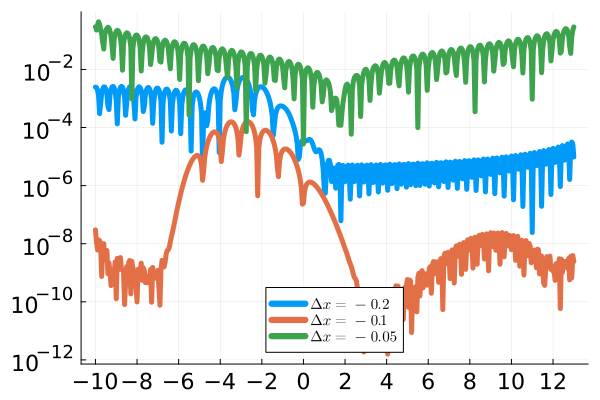

In [31]:
D=13:-0.05:-10;
ers_pdfc=errs_pdfc(4,D)

## Order of error plot

The following plot shows the order of error of the spectral discretization (CDF) using trapezoidal method for $\beta=2$ at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.05,-0.04,-0.025,-0.02$ are used.

In [32]:
β=2;
xx=-2;
result_ref=TW(β;method="spectral",step="trapz",interp=false,Δx_s=-0.001);
x_ref=result_ref[1];F_ref=result_ref[2];ind=findall(x -> x == xx, x_ref)[1];

In [33]:
del_x=[-0.05,-0.04,-0.025,-0.02];
err=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;method="spectral",step="trapz",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind2=findall(x -> x == xx, x_cdf)[1];
    err[i]=abs(F_cdf[ind2]-F_ref[ind]);
end

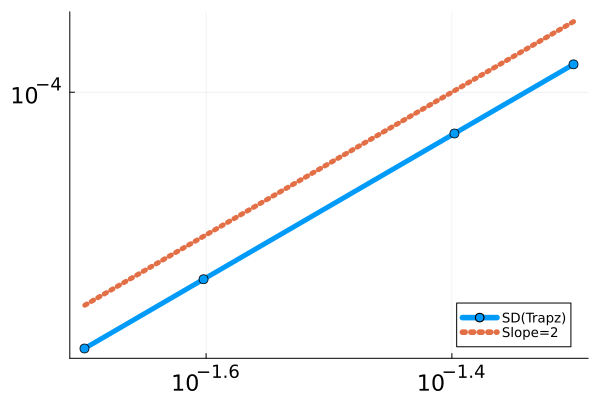

In [34]:
p=Plots.plot();
p=plot!(del_x.*(-1),vec(err),lw=5,label="SD(Trapz)",legend=:bottomright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-15),10^(-14),
        10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=9)
p=plot!(del_x.*(-1),10^(-1.2)*(del_x.*(-1)).^(2),lw=5,label="Slope=2",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:bottomright)

The following plot shows the order of error of the spectral discretization (CDF) using BDF3 for $\beta=2$ at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.05,-0.04,-0.025,-0.02$ are used.

In [35]:
β=2;
xx=-2;
result_ref3=TW(β;method="spectral",step="bdf3",interp=false,Δx_s=-0.001);
x_ref3=result_ref3[1];F_ref3=result_ref3[2];ind3=findall(x -> x == xx, x_ref3)[1];

In [36]:
err3=zeros(1,length(del_x));
del_x=[-0.05,-0.04,-0.025,-0.02];
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;method="spectral",step="bdf3",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind32=findall(x -> x == xx, x_cdf)[1];
    err3[i]=abs(F_cdf[ind32]-F_ref3[ind3]);
end

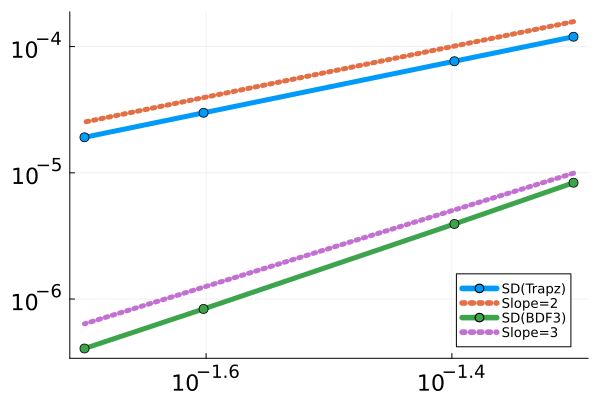

In [37]:
p=plot!(del_x.*(-1),vec(err3),lw=5,label="SD(BDF3)",legend=:bottomright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-15),10^(-14),
        10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=9)
p=plot!(del_x.*(-1),10^(-1.1)*(del_x.*(-1)).^(3),lw=5,label="Slope=3",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:bottomright)

The following plot shows the order of error of the spectral discretization (CDF) using BDF4 for $\beta=2$ at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.05,-0.04,-0.025,-0.02$ are used.

In [38]:
β=2;
xx=-2;
result_ref4=TW(β;method="spectral",step="bdf4",interp=false,Δx_s=-0.001);
x_ref4=result_ref4[1];F_ref4=result_ref4[2];ind4=findall(x -> x == xx, x_ref4)[1];

In [39]:
err4=zeros(1,length(del_x));
del_x=[-0.05,-0.04,-0.025,-0.02];
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;method="spectral",step="bdf4",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind42=findall(x -> x == xx, x_cdf)[1];
    err4[i]=abs(F_cdf[ind42]-F_ref4[ind4]);
end

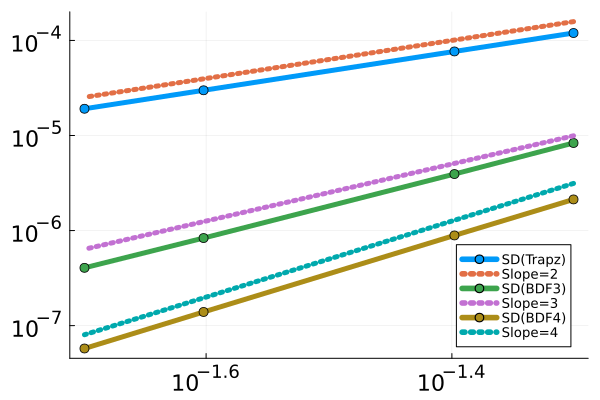

In [40]:
p=plot!(del_x.*(-1),vec(err4),lw=5,label="SD(BDF4)",legend=:bottomright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-15),10^(-14),
        10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=9)
p=plot!(del_x.*(-1),10^(-0.3)*(del_x.*(-1)).^(4),lw=5,label="Slope=4",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:bottomright)

The following plot shows the order of error of the spectral discretization (CDF) using BDF5 for $\beta=2$ at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.05,-0.04,-0.025,-0.02$ are used.

In [41]:
β=2;
xx=-2;
result_ref5=TW(β;method="spectral",step="bdf5",interp=false,Δx_s=-0.001);
x_ref5=result_ref5[1];F_ref5=result_ref5[2];ind5=findall(x -> x == xx, x_ref5)[1];

In [42]:
del_x=[-0.25,-0.2,-0.1,-0.05];
err5=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;method="spectral",step="bdf5",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind52=findall(x -> x == xx, x_cdf)[1];
    err5[i]=abs(F_cdf[ind52]-F_ref5[ind5]);
end

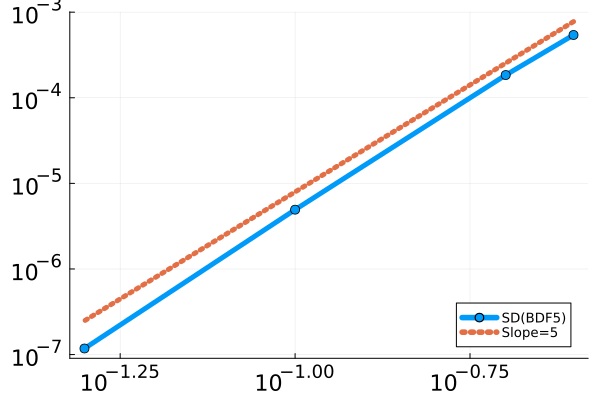

In [43]:
p=Plots.plot();
p=plot!(del_x.*(-1),vec(err5),lw=5,label="SD(BDF5)",legend=:bottomright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-15),10^(-14),
        10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=9)
p=plot!(del_x.*(-1),10^(-0.1)*(del_x.*(-1)).^(5),lw=5,label="Slope=5",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:bottomright)

The following plot shows the order of error of the spectral discretization (CDF) using BDF6 for $\beta=2$ at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.05,-0.04,-0.025,-0.02$ are used.

In [44]:
β=2;
xx=-2;
result_ref6=TW(β;method="spectral",step="bdf6",interp=false,Δx_s=-0.001);
x_ref6=result_ref6[1];F_ref6=result_ref6[2];ind6=findall(x -> x == xx, x_ref6)[1];

In [45]:
del_x=[-0.5,-0.25,-0.2];
err6=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;method="spectral",step="bdf6",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind62=findall(x -> x == xx, x_cdf)[1];
    err6[i]=abs(F_cdf[ind62]-F_ref6[ind6]);
end

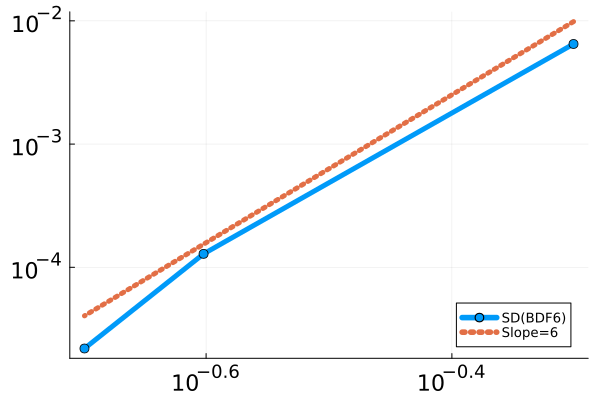

In [46]:
p=Plots.plot();
p=plot!(del_x.*(-1),vec(err6),lw=5,label="SD(BDF6)",legend=:bottomright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-15),10^(-14),
        10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=9)
p=plot!(del_x.*(-1),10^(-0.2)*(del_x.*(-1)).^(6),lw=5,label="Slope=6",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:bottomright)

## Error plots with respect to $x_{0}$

The following plot shows the absolute error of BDF5 after interpolation at $x=-2$ with respect to $x_{0}$. $\beta=1,2,4$, $x_{0}=14,12,10,8,6,4,2$.

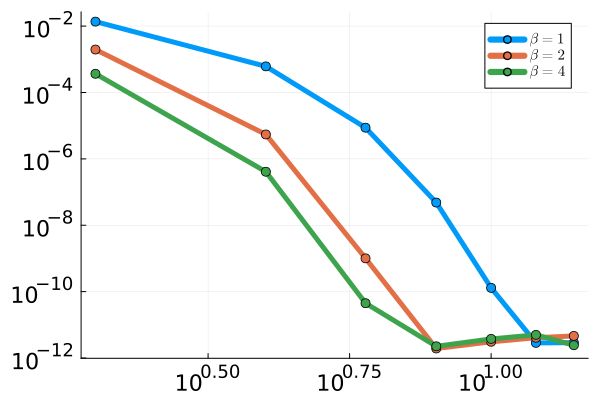

In [47]:
Beta=[1,2,4];
X=[14,12,10,8,6,4,2];
p=Plots.plot();
xx=-2;
for i=1:length(Beta)
    β=Beta[i];
    err=zeros(1,length(X));
    for j=1:length(X)
        x00=X[j];
        F_cdf=TW(β;x0=x00,method="spectral",step="bdf5");
        if β==4
            err[j]=abs(F_cdf(xx/(2^(1/6)))-cdf(TW2,xx;beta=β,num_points=300));
        else
            err[j]=abs(F_cdf(xx)-cdf(TW2,xx;beta=β,num_points=300));
        end
    end
    if β==1
        p=plot!(X,vec(err),lw=5,label=L"$\beta=1$",legend=:topright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-14),
            10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2)],marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=10)
    elseif β==2
        p=plot!(X,vec(err),lw=5,label=L"$\beta=2$",legend=:topright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-14),
            10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2)],marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=10)
    elseif β==4
        p=plot!(X,vec(err),lw=5,label=L"$\beta=4$",legend=:topright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-14),
            10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2)],marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=10)
    end
end
p